In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from object_detection.utils import dataset_util

from PIL import Image
from collections import namedtuple
import xml.etree.ElementTree as ET
import pandas as pd
import random
import os
import io

# From tensorflow/models/research/
# export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

/home/bartek/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def get_images(dir_path, n=16):
    files = os.listdir(dir_path)
    files = random.sample(files, n)
    full_paths = [plt.imread(os.path.join(dir_path, f_name)) for f_name in files]
    return full_paths


def show_images(images, columns=4, rows=4):
    assert rows*columns == len(images)
    
    fig, ax = plt.subplots(rows, columns, figsize=(12, 6))

    for plot_num, image in enumerate(images):
        i, j = plot_num // columns, plot_num % columns
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].cla()
        ax[i,j].imshow(image)

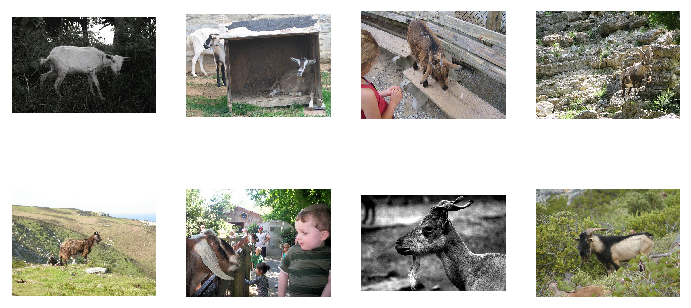

In [4]:
images = get_images('data/train_images', n=8)
show_images(images, 4, 2)

In [5]:
def get_labels_from_xml(label_file):
    all_labels = []

    tree = ET.parse(label_file)
    root = tree.getroot()
    img_file = root.find('filename').text
    img_path = root.find('path').text
    size = root.find('size')
    height = int(size.find('height').text)
    width = int(size.find('width').text)

    for obj in root.findall('object'):
        label_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        all_labels.append((img_file, img_path, width, height, label_name,
                           xmin, ymin, xmax, ymax))

    return all_labels


def get_labels_from_dir(labels_dir):
    all_labels = []
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.xml'):
            continue

        all_labels += get_labels_from_xml(os.path.join(labels_dir, label_file))
    return all_labels


def convert_to_csv(labels):
    columns = ['filename', 'path', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(labels, columns=columns)
    return df

In [10]:
for labels_dir in ['data/train_labels', 'data/eval_labels']:
    labels = get_labels_from_dir(labels_dir)
    labels = convert_to_csv(labels)
    labels.to_csv(os.path.join(labels_dir, 'labels.csv'))

labels.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
0,101.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,375,goat,94,36,402,277
1,271.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,375,goat,126,163,255,269
2,276.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,400,goat,138,101,327,400
3,28.jpg,/home/bartek/Workspace/goats/data/eval_images/...,350,366,goat,51,4,335,315
4,287.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,455,goat,351,213,452,398


In [6]:
def class_to_id(class_text):
    if class_text == 'goat':
        return 1

    
def split_by_filename(df, group):
    data = namedtuple('data', [group, 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]
    

def create_tf_example(group):
    with tf.gfile.GFile(group.path, 'rb') as fid:
        encoded_jpg = fid.read()

    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.path.split('/')[-1].encode('utf8')

    image_format = b'jpeg'
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for i, data in group.object.iterrows():
        xmins.append(data['xmin'] / width)
        xmaxs.append(data['xmax'] / width)

        ymins.append(data['ymin'] / height)
        ymaxs.append(data['ymax'] / height)

        class_text = data['class']
        classes_text.append(class_text.encode('utf8'))
        classes.append(class_to_id(class_text))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def create_tfrecord(csv_path, output_path):
    writer = tf.python_io.TFRecordWriter(output_path)
    examples = pd.read_csv(csv_path)
    grouped = split_by_filename(examples, 'path')

    for group in grouped:
        tf_example = create_tf_example(group)
        writer.write(tf_example.SerializeToString())

    writer.close()

In [7]:
csv_paths = ['data/train_labels/labels.csv', 'data/eval_labels/labels.csv']
output_paths = ['data/train.record', 'data/eval.record']

for csv, output in zip(csv_paths, output_paths):
    create_tfrecord(csv, output)